In [ ]:
import os
import time

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
DROP_COLS = ['Flow ID','Source IP','Destination IP',
             'Source Port','Destination Port','Timestamp']  # 실제 컬럼명에 맞게 정리
BAD_RATE_COLS = ['Flow Bytes/s','Flow Packets/s']           # 필요시 더 추가

def make_sequences(df, time_steps=20):
    # 1) Timestamp 파싱/정렬
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce', utc=True)
    df = df.dropna(subset=['Timestamp']).sort_values('Timestamp')

    # 2) 라벨 이진화
    df['Label'] = (df['Label'] != 'BENIGN').astype(int)

    # 3) 식별자/문제 컬럼 제거
    drop_cols = [c for c in DROP_COLS if c in df.columns] + [c for c in BAD_RATE_COLS if c in df.columns]
    df = df.drop(columns=drop_cols, errors='ignore')

    # 4) 수치형만 사용, inf/NaN 정리
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna()  # or feature-wise impute

    # 5) 슬라이딩 윈도우 (전역 흐름 순서 기준; 필요 시 Source IP 등으로 groupby 후 적용)
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    X, y = [], []
    vals = df[num_cols].values
    labels = df['Label'].values
    for i in range(len(df) - time_steps + 1):
        X.append(vals[i:i+time_steps])
        y.append(labels[i:i+time_steps].max())  # 윈도우 내 공격 존재 여부

    return np.asarray(X), np.asarray(y)


In [35]:
data_path = 'dataset/'
all_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
train_files = [f for f in all_files if 'Wednesday' not in f]
test_files = [f for f in all_files if 'Wednesday' in f]

TIME_STEPS = 10

X_train_list, y_train_list = [], []
for file_name in train_files:
    file_path = os.path.join(data_path, file_name)
    df = pd.read_csv(file_path, encoding='latin1', low_memory=False, on_bad_lines='skip')
    df.columns = df.columns.str.strip()

    X_temp, y_temp = make_sequences(df, time_steps=TIME_STEPS)
    X_train_list.append(X_temp)
    y_train_list.append(y_temp)

X_test_list, y_test_list = [], []
for file_name in test_files:
    file_path = os.path.join(data_path, file_name)
    df = pd.read_csv(file_path, encoding='latin1', low_memory=False, on_bad_lines='skip')
    df.columns = df.columns.str.strip()

    X_temp, y_temp = make_sequences(df, time_steps=TIME_STEPS)
    X_test_list.append(X_temp)
    y_test_list.append(y_temp)

X_train_seq = np.concatenate(X_train_list, axis=0)
y_train_seq = np.concatenate(y_train_list, axis=0)
X_test_seq = np.concatenate(X_test_list, axis=0)
y_test_seq = np.concatenate(y_test_list, axis=0)

scaler = MinMaxScaler()

nsamples, nsteps, nfeatures = X_train_seq.shape
X_train_2d = X_train_seq.reshape((nsamples * nsteps, nfeatures))
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_train_scaled_seq = X_train_scaled_2d.reshape((nsamples, nsteps, nfeatures))

nsamples_test, nsteps_test, nfeatures_test = X_test_seq.shape
X_test_2d = X_test_seq.reshape((nsamples_test * nsteps_test, nfeatures_test))
X_test_scaled_2d = scaler.transform(X_test_2d)
X_test_scaled_seq = X_test_scaled_2d.reshape((nsamples_test, nsteps_test, nfeatures_test))

print(f"학습 데이터 형태: {X_train_seq.shape}, {y_train_seq.shape}")
print(f"테스트 데이터 형태: {X_test_seq.shape}, {y_test_seq.shape}")
print("-" * 50)

===== 전처리 Feature 요약 =====
원본 feature 개수: 85
전처리 후 feature 개수: 77
삭제된 feature 개수: 8

[원본 Feature 목록]
['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Pack

In [25]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
class_weights_dict = dict(enumerate(class_weights))

print(f"클래스 가중치: {class_weights_dict}")

클래스 가중치: {0: np.float64(0.8878611578261594), 1: np.float64(1.144560546875)}


In [26]:
## LSTM
def create_lstm_model(input_shape, lstm_units=100, dense_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(lstm_units, activation='tanh', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("LSTM 모델 학습 시작...")
LSTM_starttime = time.time()

input_shape = (X_train_scaled_seq.shape[1], X_train_scaled_seq.shape[2])

lstm_model = create_lstm_model(input_shape=input_shape)

history = lstm_model.fit(
    X_train_scaled_seq,
    y_train_seq,
    epochs=10,
    batch_size=32,
    verbose=1,
    class_weight=class_weights_dict
)
LSTM_endtime = time.time()
LSTM_time = LSTM_endtime - LSTM_starttime
print("LSTM 모델 학습 완료.")

LSTM 모델 학습 시작...


c:\projects\UGRP_prac\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
21976/21976 ━━━━━━━━━━━━━━━━━━━━ 113s 5ms/step - accuracy: 0.9962 - loss: 0.0126
Epoch 2/10
21976/21976 ━━━━━━━━━━━━━━━━━━━━ 119s 5ms/step - accuracy: 1.0000 - loss: 3.8732e-04
Epoch 3/10
21976/21976 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - accuracy: 1.0000 - loss: 4.7234e-05
Epoch 4/10
21976/21976 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 1.0000 - loss: 1.4481e-04
Epoch 5/10
21976/21976 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - accuracy: 1.0000 - loss: 5.5605e-06
Epoch 6/10
21976/21976 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 1.0000 - loss: 2.0891e-04
Epoch 7/10
21976/21976 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 1.0000 - loss: 1.4754e-09
Epoch 8/10
21976/21976 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 1.0000 - loss: 6.3238e-10
Epoch 9/10
21976/21976 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 1.0000 - loss: 6.5976e-05
Epoch 10/10
21976/21976 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 1.0000 - loss: 5.6787e-05
LSTM 모델 학습 완료.


In [27]:

y_pred_lstm_prob = lstm_model.predict(X_test_scaled_seq).flatten()
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int)
accuracy_lstm = accuracy_score(y_test_seq, y_pred_lstm)
recall_lstm = recall_score(y_test_seq, y_pred_lstm)
f1_lstm = f1_score(y_test_seq, y_pred_lstm)
report = classification_report(y_test_seq, y_pred_lstm, target_names=['BENIGN (0)', 'ATTACK (1)'])

print("\nEvaluating model performance on the Test set...")
# Predict on the separate test set
print(f"\n--- LSTM Results---")
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Recall:   {recall_lstm:.4f}")
print(f"F1-Score: {f1_lstm:.4f}")
print("\nClassification Report:")
print(report)

21647/21647 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step

Evaluating model performance on the Test set...

--- LSTM Results---
Accuracy: 0.9845
Recall:   0.9627
F1-Score: 0.9810

Classification Report:
              precision    recall  f1-score   support

  BENIGN (0)       0.97      1.00      0.99    405592
  ATTACK (1)       1.00      0.96      0.98    287102

    accuracy                           0.98    692694
   macro avg       0.99      0.98      0.98    692694
weighted avg       0.98      0.98      0.98    692694



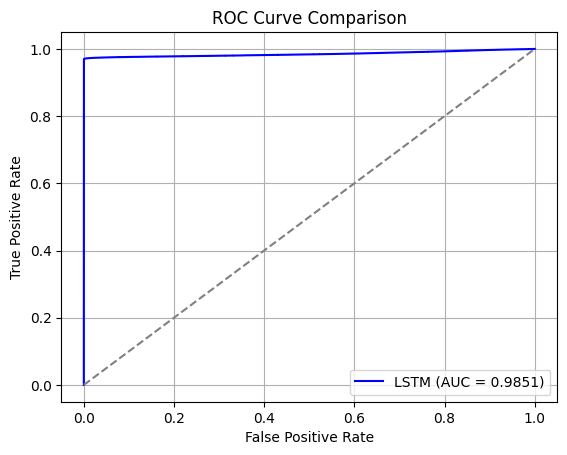

In [28]:
## ROC Curve
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve


fpr_lstm, tpr_lstm, _ = roc_curve(y_test_seq, y_pred_lstm_prob)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, color='blue', label=f'LSTM (AUC = {roc_auc_lstm:.4f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

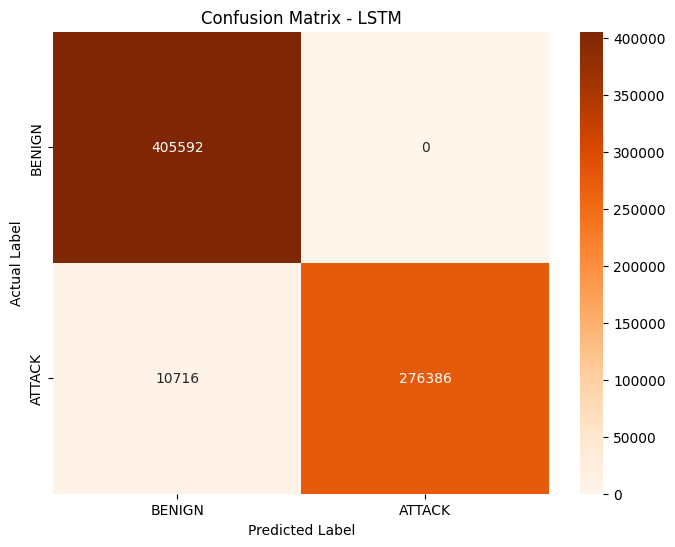

In [29]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_lstm = confusion_matrix(y_test_seq, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Oranges', xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
plt.title('Confusion Matrix - LSTM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()